In [7]:
import numpy as np
import pandas as pd

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
# import XGBoost
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

## Workflow

- compose gene_expression pipelines:
    - RFE on GENE expression data to fit classifier (XGBoost)
    - Meta data classifier 
    - compose ensemble to predict TCGA clusters (did not work) - just XGBoost was used
    
- compose validation pipeline:
    - fit RFE on CNA data to fit classifier => predict TCGA clusters
- compute loss between both

In [56]:
### SET HYPERPARAMETERS
GENES_SELECTION = 1000
CNA_SELECTION = 1000

# select which routines to run
do_xgb_feature_selection = True
do_rf_feature_selection = True
do_rf_grid_search = True

In [4]:
patient_df = pd.read_csv("/home/rimichael/Uni/biohack/bric/data_clinical_patient.txt", sep="\t", skiprows=4)
patient_df = patient_df.set_index('PATIENT_ID')
patient_df.head()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,COHORT,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,INTCLUST,AGE_AT_DIAGNOSIS,OS_MONTHS,OS_STATUS,CLAUDIN_SUBTYPE,THREEGENE,VITAL_STATUS,LATERALITY,RADIO_THERAPY,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY
PATIENT_ID,,,,,,,,,,,,,,,,,,,,
MB-0000,10.0,6.044,NaN,NO,1.0,Positve,NEUTRAL,YES,Post,4ER+,75.65,140.500000,LIVING,claudin-low,ER-/HER2-,Living,Right,YES,Ductal/NST,MASTECTOMY
MB-0002,0.0,4.020,High,NO,1.0,Positve,NEUTRAL,YES,Pre,4ER+,43.19,84.633333,LIVING,LumA,ER+/HER2- High Prolif,Living,Right,YES,Ductal/NST,BREAST CONSERVING
MB-0005,1.0,4.030,High,YES,1.0,Positve,NEUTRAL,YES,Pre,3,48.87,163.700000,DECEASED,LumB,NaN,Died of Disease,Right,NO,Ductal/NST,MASTECTOMY
MB-0006,3.0,4.050,Moderate,YES,1.0,Positve,NEUTRAL,YES,Pre,9,47.68,164.933333,LIVING,LumB,NaN,Living,Right,YES,Mixed,MASTECTOMY
MB-0008,8.0,6.080,High,YES,1.0,Positve,NEUTRAL,YES,Post,9,76.97,41.366667,DECEASED,LumB,ER+/HER2- High Prolif,Died of Disease,Right,YES,Mixed,MASTECTOMY


In [11]:
sub_patient_df = patient_df[["OS_MONTHS", "OS_STATUS", "INTCLUST","VITAL_STATUS"]]
sub_patient_df.head(n=10)

,OS_MONTHS,OS_STATUS,INTCLUST,VITAL_STATUS
PATIENT_ID,,,,
MB-0000,140.500000,LIVING,4ER+,Living
MB-0002,84.633333,LIVING,4ER+,Living
MB-0005,163.700000,DECEASED,3,Died of Disease
MB-0006,164.933333,LIVING,9,Living
MB-0008,41.366667,DECEASED,9,Died of Disease
MB-0010,7.800000,DECEASED,7,Died of Disease
MB-0014,164.333333,LIVING,3,Living
MB-0020,22.400000,DECEASED,4ER-,Died of Disease
MB-0022,99.533333,DECEASED,3,Died of Other Causes


In [6]:
cna_df = pd.read_csv("/home/rimichael/Uni/biohack/bric/data_CNA.txt", sep="\t")
cna_df = cna_df.drop(columns="Entrez_Gene_Id")
cna_df = cna_df.T
cna_df.columns = cna_df.iloc[0]
cna_df = cna_df.drop("Hugo_Symbol")

cna_df.head(10)

Hugo_Symbol,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
MB-0000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MB-0039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-1,0,0
MB-0045,-1,-1,0,-1,-1,-1,-1,0,0,2,...,0,0,0,0,0,1,-1,0,-2,0
MB-0046,0,0,0,-1,-1,-1,-1,0,-1,0,...,0,0,-1,-1,0,0,0,0,-1,0
MB-0048,0,0,1,0,0,0,0,0,-1,0,...,0,1,0,0,0,0,0,1,-1,0
MB-0050,0,0,0,0,0,0,0,0,-1,0,...,-1,0,1,1,0,0,0,0,-1,0
MB-0053,0,0,0,0,0,0,0,0,0,1,...,0,0,-1,-1,1,1,1,0,0,0
MB-0062,-1,-1,0,2,2,2,2,-1,1,1,...,-1,-1,1,1,0,1,1,0,-1,1
MB-0064,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MB-0066,0,0,-1,0,0,0,0,0,-1,0,...,0,-1,-1,-1,1,-1,-1,0,-1,0


In [9]:
# combined dataset
cna_data_df = cna_df.join(sub_patient_df, how="left")
cna_train_df = cna_data_df.drop(columns=["OS_STATUS", "OS_MONTHS", "VITAL_STATUS"]).dropna()
y = cna_train_df["INTCLUST"]
y

MB-0000    4ER+
MB-0039    4ER+
MB-0045    4ER-
MB-0046       5
MB-0048    4ER+
           ... 
MB-7133       1
MB-0156    4ER+
MB-0210    4ER+
MB-0635    4ER+
MB-0876    4ER-
Name: INTCLUST, Length: 1898, dtype: object

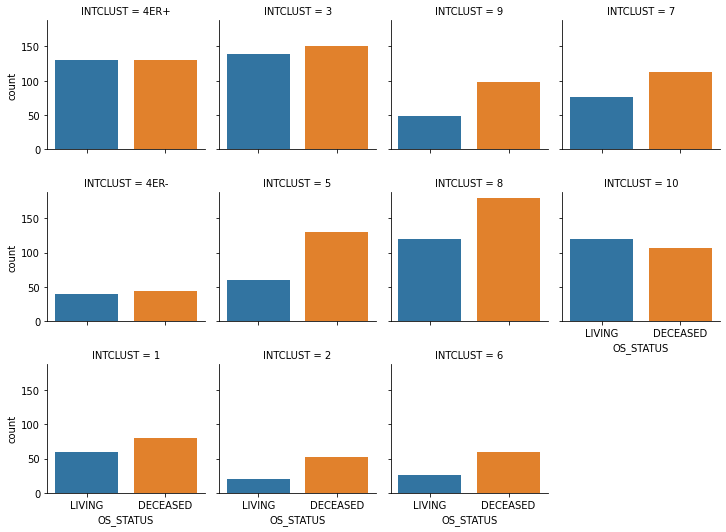

In [18]:
# plot some patient data
sns.catplot("OS_STATUS", col="INTCLUST", col_wrap=4, 
            data=sub_patient_df, height=2.5, kind="count")
plt.show();

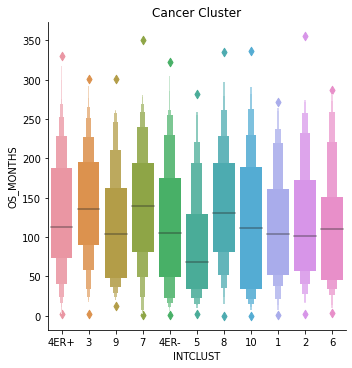

In [19]:
sns.catplot(x="INTCLUST", y="OS_MONTHS", kind="boxen", data=sub_patient_df)
plt.title("Cancer Cluster")
plt.show();

In [20]:
cna_train_df = cna_train_df.drop(columns="INTCLUST")

### Read in Gene expression data

In [22]:
# take expression into account
expression_df = pd.read_csv("/home/rimichael/Uni/biohack/bric/data_expression_median.txt",sep="\t")
expression_df = expression_df.set_index("Hugo_Symbol")
expression_df = expression_df.drop(columns="Entrez_Gene_Id").T
expression_df.head(10)

Hugo_Symbol,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,...,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
MB-0362,8.676978,6.075331,5.453928,4.994525,5.838270,6.397503,7.906217,5.259461,5.702379,6.930741,...,5.271343,5.680321,7.688492,8.084979,5.161796,6.353215,4.836483,7.304643,5.251843,5.049591
MB-0346,9.653589,6.687887,5.454185,5.346010,5.600876,5.246319,8.267256,5.380069,5.521794,6.141689,...,5.942887,5.461069,7.804165,8.349115,5.197392,6.132355,5.316819,7.933324,5.450611,5.316790
MB-0386,9.033589,5.910885,5.501577,5.247467,6.030718,10.111816,7.959291,5.262024,5.689533,6.529312,...,5.174498,5.304030,7.934309,8.406332,8.087722,6.366335,5.466419,7.580336,5.235394,5.461617
MB-0574,8.814855,5.628740,5.471941,5.316523,5.849428,6.116868,9.206376,5.396576,5.439130,6.430102,...,5.116749,5.632249,7.744562,8.310019,5.780062,6.424048,5.193150,6.903654,5.091927,5.227130
MB-0503,9.274265,5.908698,5.531743,5.244094,5.964661,7.828171,8.706646,5.167213,5.417484,6.684893,...,5.402314,5.472185,7.701394,8.137014,5.498185,6.214301,5.274600,6.839417,5.315224,5.027476
MB-0641,9.286585,6.206729,5.372668,5.167365,5.783374,8.744149,8.518929,5.228937,5.629885,5.632753,...,5.489447,5.543384,7.690236,8.009209,5.408243,6.175542,5.299248,6.326814,5.543680,5.086662
MB-0201,8.437347,6.095592,5.693519,5.189106,5.737572,5.480091,7.478413,5.430230,5.686286,5.866132,...,5.357598,5.325600,7.837494,8.818098,5.291289,6.003532,5.555575,8.375567,5.444825,4.991999
MB-0218,8.569973,6.383530,5.401276,5.416517,5.923928,5.671577,8.410583,5.200576,5.770271,7.403098,...,5.415931,5.346443,7.360295,7.969567,5.104648,6.501156,5.241082,6.534520,5.420087,5.493967
MB-0316,8.892102,5.773691,5.567946,5.339133,5.902223,5.509498,7.779545,5.383724,5.510622,6.881749,...,5.733573,5.504519,7.679597,8.721196,5.218413,6.617991,5.220612,7.143399,5.307056,5.062520
MB-0189,8.922748,6.461321,5.410957,5.389980,5.536764,7.196945,8.385897,5.397070,5.594352,6.484873,...,5.412129,5.597104,8.096537,8.073800,5.220937,6.262962,5.234383,7.149541,5.174048,5.583954


In [23]:
# do recursive feature elimination for a tree fit on gene expression data
# split gene data into test and training
gene_data_df = expression_df.join(patient_df["INTCLUST"], how="left").dropna()
gene_X_df = gene_data_df.drop(columns="INTCLUST")
gene_y_df = gene_data_df["INTCLUST"]

X_gene_train, X_gene_test, y_gene_train, y_gene_test = train_test_split(gene_X_df, 
                                                                        gene_y_df, test_size=0.22, random_state=1234)

X_gene_train.head(10)

,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,PAPD4,AI082173,SLC17A3,SDS,...,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
MB-4966,9.291692,6.411249,5.605282,5.063649,6.003271,6.735609,9.128725,5.314463,5.578489,7.171869,...,5.260648,5.234746,7.100904,7.983542,5.057194,6.365567,5.373097,7.583714,5.509426,5.554543
MB-0442,9.113783,6.015336,5.669313,5.426407,5.665439,8.460771,9.007343,5.244298,5.535573,5.595616,...,5.522175,5.598926,7.183373,7.944622,5.400700,5.634848,5.251053,6.767750,5.251676,5.230243
MB-4140,9.472043,5.910744,5.426901,5.223268,7.138441,5.779727,8.222894,5.101516,5.761124,6.318411,...,5.670318,5.454181,8.068413,8.329161,5.334215,6.494326,5.328042,6.618754,5.143839,5.646772
MB-0375,8.836655,5.852575,5.231698,5.151452,5.678047,5.416510,8.814137,5.320135,5.389053,6.179701,...,5.549034,5.628941,7.675028,8.627779,5.331394,6.436519,5.247447,7.459989,5.571634,5.295922
MB-4944,9.476825,7.109797,5.686820,5.263275,5.864668,5.413119,8.164442,5.287566,5.531523,6.285579,...,5.262310,5.374889,7.291418,8.604917,5.093681,6.486328,5.266707,7.847362,5.421091,5.348771
MB-5267,9.578409,6.564438,5.254258,5.386076,5.896931,7.342678,8.772796,5.390979,5.689784,6.843271,...,5.348055,5.583568,7.742490,8.059186,5.477331,6.204938,5.240416,6.763843,5.371688,4.783277
MB-3297,8.670956,5.816641,4.968347,5.185354,5.782669,5.803720,8.022189,5.392572,5.483405,6.622347,...,5.466416,5.514664,7.049731,9.245420,5.357823,6.576368,5.336841,6.922320,5.303597,4.998942
MB-0508,8.629996,6.414613,5.525568,5.442465,5.545630,8.056770,8.362950,5.204814,5.706339,6.567588,...,5.313690,5.533980,7.719020,8.533181,5.412549,6.351128,5.234175,6.576710,5.376753,5.521467
MB-5453,9.606915,7.427494,5.534115,5.062191,5.927409,5.927031,8.520545,5.129501,5.550549,5.841476,...,5.566320,5.538543,7.048923,7.560101,5.397010,7.088676,5.216496,7.248336,5.544276,5.436415
MB-5511,9.281877,5.467422,5.587265,5.265825,5.550846,5.368071,8.767025,5.238591,5.413615,7.090043,...,5.593733,5.367201,8.137236,7.905607,5.226710,7.107215,5.477828,6.655007,5.422046,5.532680


In [29]:
print("CNA dim:")
print(cna_df.shape)

total_data_df = cna_df.join(patient_df["INTCLUST"], how="left")
total_data_df = total_data_df.join(expression_df, how="inner", rsuffix="_expr").dropna()

print("CNA-expression join dim:")
print(total_data_df.shape)

#X_train, X_test, y_train, y_test
y_total = total_data_df["INTCLUST"]
X_total = total_data_df.drop(columns="INTCLUST")

print("X total dim:")
print(X_total.shape)

X_total.head()

CNA dim:
(2173, 22544)
CNA-expression join dim:
(1885, 46913)
X total dim:
(1885, 46912)


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,BX115874,BX107598,UGCGL1,VPS72_expr,CSMD3_expr,CC2D1A_expr,CB986545,IGSF9_expr,DA110839,FAM71A_expr
MB-0000,0,0,0,0,0,0,0,0,0,0,...,5.329883,5.745324,7.021679,8.010657,5.299815,6.235804,5.349555,5.947404,5.615147,5.133576
MB-0039,0,0,0,0,0,0,0,0,0,0,...,5.951742,5.928352,7.926861,7.331212,5.450666,5.985447,5.458363,5.390357,5.706905,5.498739
MB-0045,-1,-1,0,-1,-1,-1,-1,0,0,2,...,5.379279,5.761502,7.807015,8.301804,5.313254,6.281194,5.390784,6.264153,5.426428,5.547820
MB-0046,0,0,0,-1,-1,-1,-1,0,-1,0,...,5.204814,5.667425,7.715507,8.488727,5.307310,6.071653,5.264978,7.837516,5.321490,5.390555
MB-0048,0,0,1,0,0,0,0,0,-1,0,...,5.520178,5.582338,7.194426,7.496171,5.176560,6.065291,5.180065,5.651414,5.358560,5.825701


#### Split Data into Training and Testing

In [30]:
X_cna_train, X_cna_test, y_cna_train, y_cna_test = train_test_split(cna_train_df, y, 
                                                                    test_size=0.22, random_state=1234)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size=0.22, random_state=1234)

In [33]:
if do_rf_feature_selection:
    cna_clf = RFE(RandomForestClassifier(max_depth=25, max_leaf_nodes=30, 
                                           n_estimators=300, n_jobs=6),
                   CNA_SELECTION, step=0.2, verbose=1)

    cna_clf.fit(X_cna_train, y_cna_train)
    print("CNA-data RFE training score:")
    print(cna_clf.score(X_cna_train, y_cna_train))
    print("CNA-data RFE Random Forest - test score:")
    print(cna_clf.score(X_cna_test, y_cna_test))


Fitting estimator with 22544 features.
Fitting estimator with 18036 features.
Fitting estimator with 13528 features.
Fitting estimator with 9020 features.
Fitting estimator with 4512 features.
CNA-data RFE training score:
0.6743243243243243
CNA-data RFE Random Forest - test score:
0.6244019138755981


In [35]:
# subselect most important CNA features
top_cna_list = list(X_cna_train.iloc[:, cna_clf.support_])
top_cna_df = X_cna_train.iloc[:, cna_clf.support_]
top_cna_df.head()

,AAMDC,AARD,ABCA10,ABCA3,ABCA5,ABCA6,ABCA8,ABCA9,ABCC1,ABCC6,...,ZNF707,ZNF747,ZNF75A,ZNF768,ZNF771,ZP2,ZPBP2,ZSCAN10,ZSCAN32,ZSWIM6
MB-5300,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
MB-4648,2,2,2,1,2,2,2,2,1,1,...,2,1,1,1,1,1,2,1,1,0
MB-0899,0,0,0,1,0,0,0,0,1,1,...,0,1,1,1,1,1,-1,1,1,0
MB-4317,-1,2,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,2,0,0,0
MB-4333,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# to plot feature importance we have to build a tree classifier from top features
_rf_cna_clf = RandomForestClassifier(max_depth=25, max_leaf_nodes=30, 
                                           n_estimators=300, n_jobs=6)
_rf_cna_clf.fit(X_cna_train[top_cna_list], y_cna_train)
_rf_cna_clf.score(X_cna_test[top_cna_list], y_cna_test)

0.6220095693779905

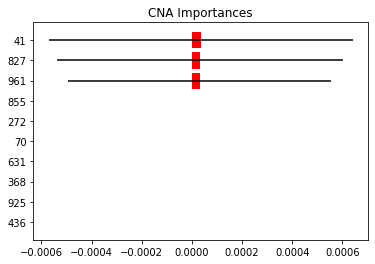

In [47]:
# plot most important CNAs given the data
cna_importance = _rf_cna_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in _rf_cna_clf.estimators_],
             axis=0)
ix = np.argsort(cna_importance)

plt.figure()
plt.title("CNA Importances")
plt.barh(range(top_cna_df.shape[1])[:10], cna_importance[ix][:10],
       color="r", xerr=std[ix][:10], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(10), ix[:10])
plt.show()

In [48]:
if do_rf_feature_selection:
    gene_expr_clf = RFE(
        RandomForestClassifier(max_depth= 25, max_leaf_nodes= 30, 
                                           n_estimators= 300, n_jobs=6),
                   GENES_SELECTION, step=0.2, verbose=1)

    gene_expr_clf.fit(X_gene_train, y_gene_train)
    print("Gene data RFE Random Forest - Train score:")
    print(gene_expr_clf.score(X_gene_train, y_gene_train))
    print("Gene data RFE Random Forest - test score:")
    print(gene_expr_clf.score(X_gene_test, y_gene_test))

Fitting estimator with 24368 features.
Fitting estimator with 19495 features.
Fitting estimator with 14622 features.
Fitting estimator with 9749 features.
Fitting estimator with 4876 features.
Gene data RFE Random Forest - Train score:
0.8801624915368991
Gene data RFE Random Forest - test score:
0.7338129496402878


#### Most 1000 informative genes

In [49]:
top_gene_list = list(X_gene_train.iloc[:, gene_expr_clf.support_])
top_gene_train_df = X_gene_train.iloc[:, gene_expr_clf.support_]
top_gene_train_df.head(10)

,PDIA6,EFCAB4A,C17orf37,CEBPB,BRF2,MASTL,PSME4,COMMD5,RAB25,MRFAP1L1,...,CPNE3,TFF3,UNKL,RRNAD1,DOCK11,FAM20B,DCTPP1,STUB1,VPS72,IGSF9
MB-4966,7.521641,9.804683,6.141009,11.011958,7.613662,6.323027,8.712808,8.196188,10.573690,10.431386,...,10.036954,13.197578,6.584928,8.131058,7.733513,9.393831,8.473215,8.914683,7.983542,7.583714
MB-0442,8.361666,9.531217,5.852212,10.817736,8.186021,6.008106,8.136282,8.292642,8.823022,9.765207,...,9.949628,10.199443,6.633448,8.151290,7.953477,8.442770,9.014684,9.251609,7.944622,6.767750
MB-4140,6.736279,12.295350,6.502238,10.740723,8.130600,6.377216,9.605260,8.321176,10.700570,10.606180,...,9.880400,13.717232,6.988285,8.815094,6.426912,9.733669,7.964634,9.377429,8.329161,6.618754
MB-0375,8.813968,9.665681,6.010486,12.849048,7.204493,7.029943,9.672964,8.635086,10.214855,10.137762,...,10.554612,8.268275,6.456713,7.755983,7.282390,8.983534,9.811742,8.636361,8.627779,7.459989
MB-4944,8.262581,8.483205,6.253116,10.895761,7.873961,6.702506,9.769464,8.334461,10.593718,10.196877,...,10.983537,13.781272,7.199055,9.143433,6.219195,9.293867,9.646449,10.022016,8.604917,7.847362
MB-5267,7.892648,9.268920,6.122908,11.608128,7.406816,6.492400,9.517273,8.600376,10.119318,10.323613,...,10.688055,12.771418,6.759240,7.858374,7.107057,8.629402,9.383735,9.535231,8.059186,6.763843
MB-3297,8.609993,9.773098,6.357442,12.240355,6.968072,7.310023,10.312562,8.718048,10.611648,9.642632,...,10.798615,7.096915,5.841025,7.897587,7.449151,8.776852,9.702629,8.646364,9.245420,6.922320
MB-0508,8.332768,9.093160,6.369558,11.796885,7.071496,7.103566,8.646321,8.567426,10.221605,10.455735,...,9.720194,13.731721,6.832479,8.099919,7.321852,8.879755,9.586548,9.266658,8.533181,6.576710
MB-5453,7.652164,10.257507,5.867294,12.061691,7.446204,6.139252,8.954174,8.410416,10.002296,10.512787,...,10.243842,11.820328,6.564174,7.911946,7.120426,8.521217,8.984720,8.610122,7.560101,7.248336
MB-5511,8.674004,8.785903,6.249050,10.277542,7.198758,6.741730,11.168545,8.973517,10.544454,10.222051,...,11.626535,7.162392,6.647755,7.857081,7.831886,9.176839,9.950416,9.335948,7.905607,6.655007


### Sanity Check: See correlation matrix for the identified genes

In [50]:
top_gene_train_corr = top_gene_train_df.corr()
top_gene_train_corr.head()

,PDIA6,EFCAB4A,C17orf37,CEBPB,BRF2,MASTL,PSME4,COMMD5,RAB25,MRFAP1L1,...,CPNE3,TFF3,UNKL,RRNAD1,DOCK11,FAM20B,DCTPP1,STUB1,VPS72,IGSF9
PDIA6,1.000000,-0.269328,-0.011869,0.428309,-0.052878,0.404933,0.202331,0.237578,0.006804,-0.463346,...,0.078635,-0.408033,-0.308587,-0.318239,0.185555,-0.113172,0.356489,-0.085698,0.277297,0.092652
EFCAB4A,-0.269328,1.000000,0.067758,-0.211259,-0.184619,-0.194999,-0.000580,-0.250750,0.342697,0.134668,...,-0.110217,0.290408,0.107599,0.338575,-0.279814,0.099248,-0.112821,0.171779,-0.002824,0.194027
C17orf37,-0.011869,0.067758,1.000000,-0.029534,-0.038952,0.069498,0.094271,0.120094,0.114818,-0.139392,...,0.138391,0.137452,0.006469,-0.028184,-0.046358,0.010770,-0.001551,0.072635,0.035845,0.138376
CEBPB,0.428309,-0.211259,-0.029534,1.000000,-0.117134,0.463064,0.379870,0.191772,-0.096516,-0.470255,...,-0.084754,-0.573644,-0.192459,-0.274318,0.197112,-0.053062,0.001421,-0.268850,0.269774,0.168381
BRF2,-0.052878,-0.184619,-0.038952,-0.117134,1.000000,0.002944,-0.158703,0.155703,-0.027260,0.139317,...,0.181977,0.137311,0.181777,0.043313,-0.218642,0.052414,-0.002685,0.142674,-0.014336,-0.036132


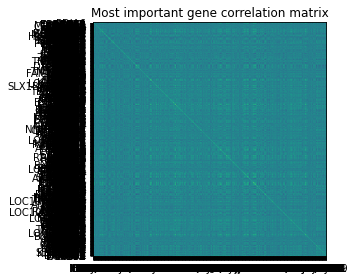

In [51]:
# plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(top_gene_train_corr)

ax.set_xticks(np.arange(top_gene_train_corr.shape[0]))
ax.set_yticks(np.arange(top_gene_train_corr.shape[0]))
ax.set_xticklabels(list(top_gene_train_corr))
ax.set_yticklabels(list(top_gene_train_corr))

ax.set_title("Most important gene correlation matrix")
fig.tight_layout()
plt.show()

In [52]:
# gridsearch parameters
parameters={'n_estimators': [50, 100, 300, 500],
           'max_depth': [2, 10, 25],
           'max_leaf_nodes': [3, 5, 10, 20, 30]}

rf_clf = RandomForestClassifier()
gs_clf = GridSearchCV(rf_clf, parameters, n_jobs=8)

In [53]:
if do_rf_grid_search:
    gs_clf.fit(X_cna_train, y_cna_train)

    # see optimal grid search results
    for mean, std, params in zip(gs_clf.cv_results_.get('mean_test_score'), 
                                 gs_clf.cv_results_.get('std_test_score'), 
                                 gs_clf.cv_results_.get('params')):
        print(mean, std*2, params)

0.4621621621621622 0.04727798833658351 {'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 50}
0.46959459459459457 0.07376942737273612 {'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 100}
0.4722972972972973 0.0644411838787371 {'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 300}
0.475 0.060070569651061834 {'max_depth': 2, 'max_leaf_nodes': 3, 'n_estimators': 500}
0.4736486486486487 0.0575555119974239 {'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 50}
0.4817567567567568 0.05415531056625372 {'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 100}
0.48310810810810806 0.05812381937190963 {'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 300}
0.4763513513513513 0.06236746356332068 {'max_depth': 2, 'max_leaf_nodes': 5, 'n_estimators': 500}
0.4871621621621621 0.0682933987486123 {'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 50}
0.4918918918918919 0.06628512685638226 {'max_depth': 2, 'max_leaf_nodes': 10, 'n_estimators': 100}
0.4777027027027027 0.0534766457767

## Create ensemble pipeline

In [58]:
# load metadata
meta_df = pd.read_csv('/home/rimichael/Uni/biohack/biohack2020/data/meta/new_meta.tsv','\t')
x_meta_df = meta_df[["AGE", "TYPE", "MONTHS", "SURVIVAL"]]
y_meta_df = meta_df[["INTCLUST"]]
x_meta_train, x_meta_test, y_meta_train, y_meta_test = train_test_split(x_meta_df, y_meta_df, 
                                                                        test_size=0.25)
meta_df = meta_df.set_index("ID")
meta_df.head()

,AGE,TYPE,MONTHS,SURVIVAL,INTCLUST
ID,,,,,
MB-0000,75.65,2,140.500000,1,4ER+
MB-0002,43.19,2,84.633333,1,4ER+
MB-0005,48.87,2,163.700000,2,3
MB-0010,78.77,2,7.800000,2,7
MB-0014,56.45,2,164.333333,1,3


In [60]:
# build total dataframe from gene metadata+ gene data
ensemble_data = meta_df.join(gene_data_df.drop(columns="INTCLUST"), how="left").dropna()
y_ensemble_data = ensemble_data["INTCLUST"]

ensemble_data = ensemble_data.drop(columns="INTCLUST")

X_ens_train , X_ens_test, y_ens_train, y_ens_test = train_test_split(ensemble_data, y_ensemble_data, 
                                                                        test_size=0.25)
print(X_ens_train.shape)
X_ens_train.head(10)

(1242, 24372)


,AGE,TYPE,MONTHS,SURVIVAL,RERE,RNF165,CD049690,BC033982,PHF7,CIDEA,...,BX115874,BX107598,UGCGL1,VPS72,CSMD3,CC2D1A,CB986545,IGSF9,DA110839,FAM71A
ID,,,,,,,,,,,,,,,,,,,,,
MB-0346,32.61,2,20.433333,2,9.653589,6.687887,5.454185,5.346010,5.600876,5.246319,...,5.942887,5.461069,7.804165,8.349115,5.197392,6.132355,5.316819,7.933324,5.450611,5.316790
MB-0270,29.98,2,337.033333,1,8.174118,6.254576,5.537246,5.436566,5.772685,6.301700,...,5.512750,5.460282,8.161645,8.200266,5.189258,6.318683,5.423642,7.550059,5.510215,4.919668
MB-7114,55.57,2,123.266667,1,8.905342,5.433246,5.516984,5.234662,5.545406,5.173806,...,5.303475,5.515471,7.380274,9.171597,5.222982,6.269195,5.309287,7.138486,5.331186,5.264369
MB-5184,79.76,1,89.333333,2,9.323737,6.393588,5.452471,5.215942,5.760665,6.630878,...,5.308574,5.704574,7.758682,7.626214,5.264524,6.091861,5.375902,7.320169,5.530041,5.053331
MB-7151,59.06,2,144.433333,1,8.355286,7.751008,5.443046,5.086998,5.667819,5.416891,...,5.241725,5.725414,8.288577,9.619249,5.195478,6.362351,5.350022,7.257815,5.400396,5.602404
MB-5281,55.72,2,79.300000,1,9.482070,6.047958,5.568638,5.117033,5.835441,6.212818,...,5.323191,5.711187,7.843637,7.736749,5.468666,6.542453,5.171524,5.825246,5.392558,5.239307
MB-4098,68.55,2,176.366667,1,9.386074,9.149295,5.682664,5.554572,7.309149,5.409365,...,7.656987,5.467515,9.171597,7.747953,5.416959,7.401279,5.472270,6.367210,5.357167,6.133683
MB-6248,51.22,2,182.833333,1,8.404626,7.398109,5.966757,5.070789,5.546038,5.983338,...,5.215630,5.806205,7.980339,9.577290,5.472384,6.244788,5.190771,8.602651,5.250047,5.167795
MB-0643,73.46,2,19.733333,2,8.369250,6.812682,5.402884,5.412475,5.660120,5.138726,...,6.065942,5.863343,7.431423,8.188346,5.281280,6.227693,5.305176,7.479297,5.233302,5.905303


In [62]:
# fit metadata classifier
et = ExtraTreesClassifier(n_jobs=-1, n_estimators=1000, max_depth=7, min_samples_leaf=2)
et.fit(x_meta_train, y_meta_train)
train_score = et.score(x_meta_train, y_meta_train)
test_score = et.score(x_meta_test, y_meta_test)

print("MetaData Train Score:")
print(train_score)
print("MetaData Test Score:")
print(test_score)

<ipython-input-62-84b8cac2f0fb>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  et.fit(x_meta_train, y_meta_train)


MetaData Train Score:
0.3403590944574551
MetaData Test Score:
0.1990632318501171


In [63]:
class ColumnSelector(object):
    """
    A feature selector for scikit-learn's Pipeline class that returns
    specified columns from a numpy array.

    """

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, y=None):
        return X[:, self.cols]

    def fit(self, X, y=None):
        return self

In [65]:
%%time
if do_xgb_feature_selection:
    gene_clf = RFE(XGBClassifier(n_estimators=150, booster="gbtree", 
                                 learning_rate=0.1, max_depth=6,
                               nthread=6, verbose=2),
                   GENES_SELECTION, step=0.25, verbose=1)
    print("Fit RFE with XGBoost-Trees on Gene expression...")
    gene_clf.fit(X_gene_train, y_gene_train)
    print("\nExtracted XGBoost Model - Test Score: ")
    gene_clf.score(X_gene_test, y_gene_test)

Fit RFE with XGBoost-Trees on Gene expression...
Fitting estimator with 24368 features.
Fitting estimator with 18276 features.
Fitting estimator with 12184 features.
Fitting estimator with 6092 features.

Extracted XGBoost Model - Test Score: 
CPU times: user 8h 34min 25s, sys: 57 s, total: 8h 35min 22s
Wall time: 1h 33min 41s


### get best performing genes for METABRIC data

In [66]:
gene_list = list(X_gene_train.iloc[:, gene_clf.support_])
gene_train_df = X_gene_train.iloc[:, gene_clf.support_]

gene_train_df.head()

,RNF165,AI082173,SDS,CR749394,TAF15,BC033582,TM2D1,ITGA10,MARS2,MAGEC1,...,MCM10,TFF3,RRNAD1,R00495,GSPT2,EHBP1,FAM20B,VPS72,CSMD3,IGSF9
MB-4966,6.411249,5.314463,7.171869,5.449496,10.375599,5.219208,9.993588,6.278984,6.329347,5.441179,...,6.364241,13.197578,8.131058,5.738233,7.185659,8.269454,9.393831,7.983542,5.057194,7.583714
MB-0442,6.015336,5.244298,5.595616,5.372319,10.053390,5.429442,9.416736,6.397087,5.870693,5.423053,...,5.635470,10.199443,8.151290,5.400951,7.583288,8.764773,8.442770,7.944622,5.400700,6.767750
MB-4140,5.910744,5.101516,6.318411,5.283924,10.939640,5.313709,9.033669,6.421508,5.833153,5.473787,...,6.301619,13.717232,8.815094,5.610196,6.847700,7.732358,9.733669,8.329161,5.334215,6.618754
MB-0375,5.852575,5.320135,6.179701,5.333260,9.948910,5.280533,8.833708,6.254444,6.500594,5.306772,...,7.224271,8.268275,7.755983,5.389648,8.307310,7.764330,8.983534,8.627779,5.331394,7.459989
MB-4944,7.109797,5.287566,6.285579,5.313447,10.513836,5.356672,8.909695,7.155699,6.181256,5.170912,...,7.060508,13.781272,9.143433,5.356835,7.825783,8.296569,9.293867,8.604917,5.093681,7.847362


In [67]:
# save metabric XGBoost Model
with open("/home/rimichael/Uni/biohack/gene_model.sav", "wb") as outfile:
    pickle.dump(gene_clf, outfile)

## Apply Models to TCGA data

In [68]:
# load TCGA data - expression 1
tcga_df = pd.read_csv("/home/rimichael/Uni/biohack/tcga/data_expression_median.txt", 
                      sep="\t", index_col="Hugo_Symbol")
tcga_df = tcga_df.drop(columns="Entrez_Gene_Id").T.dropna()

In [69]:
# load TCGA data - expression 2
tcga_df_v2 = pd.read_csv("/home/rimichael/Uni/biohack/tcga/data_RNA_Seq_v2_expression_median.txt", 
                         sep="\t", index_col="Hugo_Symbol")
tcga_df_v2 = tcga_df_v2.drop(columns="Entrez_Gene_Id").T.dropna()

In [70]:
tcga_df.head(10)

Hugo_Symbol,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,C10orf90,ZHX3,ERCC5,GPR98,RXFP3,...,SLC2A11,GRIP2,GPLD1,RAB8A,RXFP2,PIK3IP1,SLC39A6,SNRPD2,AQP7,CTSC
TCGA-A1-A0SE-01,0.181417,0.89075,0.716000,0.13175,0.957833,-0.59025,-0.043667,-0.23850,-0.152250,0.4425,...,0.185833,-0.18750,-0.440000,0.5352,0.2570,2.81075,2.0736,-0.0675,-1.0095,-1.1553
TCGA-A1-A0SH-01,0.461500,2.25925,0.417125,0.32500,2.285500,-1.72675,0.420500,0.00725,-0.696000,0.2960,...,-0.001333,-0.26900,-0.996667,0.8484,0.6025,2.36950,0.5013,-0.1963,-1.0765,-0.7658
TCGA-A1-A0SJ-01,0.877000,0.43775,0.115000,0.75775,-0.089333,-1.78375,0.251000,0.03525,-0.640625,0.6885,...,0.455333,0.00025,-0.099500,0.1940,-0.1235,2.85725,3.0967,0.3321,1.5910,-0.7459
TCGA-A1-A0SK-01,1.412333,-0.63725,0.492875,0.94325,-1.233167,-2.75500,-1.331500,0.79100,0.014500,-0.0600,...,-0.669333,-0.11650,-0.634167,0.8949,0.0855,1.86000,-0.4288,0.0048,-1.0275,-0.6338
TCGA-A1-A0SM-01,1.666750,2.58000,-0.525000,0.64175,1.591500,-1.86975,0.059833,-0.17725,0.091875,0.1710,...,-0.480333,-0.32475,-1.282167,0.7529,0.6820,2.63200,0.7469,-0.7540,-1.0140,-0.9661
TCGA-A1-A0SP-01,0.055417,0.16675,0.396000,0.02600,-0.260500,-2.13350,-1.090667,-0.56675,-1.448500,0.7785,...,-0.130833,-0.30950,-0.811500,0.3926,-0.3370,1.23125,-1.4531,0.1176,-0.5720,0.5423
TCGA-A2-A04N-01,-0.486000,1.18425,0.504750,0.53325,0.583000,-1.64900,-0.183667,0.46675,0.383625,0.2610,...,-0.270667,-0.39000,-1.203500,-0.7215,0.9085,1.37325,1.0834,0.6446,-1.0025,-0.1929
TCGA-A2-A04P-01,-0.947750,0.96650,0.400875,-1.72625,-0.716333,1.33675,-0.253833,0.42300,-0.235625,1.1025,...,-0.626333,-0.01050,-0.967000,1.2088,0.9995,0.51000,-3.7138,0.4483,0.0825,0.3699
TCGA-A2-A04R-01,-0.252000,0.95850,0.916500,1.17150,-0.390000,-2.30575,-0.356667,-0.30150,0.531500,0.4445,...,-0.064167,-0.64375,-0.273333,-0.2317,-0.2865,1.21075,4.6426,0.0549,-0.4510,-1.9326
TCGA-A2-A04T-01,-0.095417,-0.33475,0.627125,-0.63550,-0.466167,0.10625,-0.549167,1.12750,-1.825750,0.6805,...,0.327667,-0.41475,-0.972667,-0.5302,0.4550,0.77300,-1.0049,0.1524,-0.4250,0.6048


In [113]:
tcga_df_v2

Hugo_Symbol,UBE2Q2P2,HMGB1P1,LOC155060,RNU12-2P,SSX9,CXORF67,EFCAB8,SRP14P1,LOC391343,TRIM75P,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,TPTEP1,AKR1C6P
TCGA-A1-A0SB-01,14.3935,116.3870,279.7612,0.4505,0.0,0.9010,0.9010,1.8020,0.0000,0.4505,...,95.9568,519.4279,1415.9252,19.3716,1364.5681,6186.7327,1931.2986,1436.1978,552.3144,0.0000
TCGA-A1-A0SD-01,11.3241,60.2630,83.6986,0.3308,0.0,0.6616,0.3308,4.6315,0.3308,0.3308,...,96.2700,578.2814,1225.7051,33.0825,868.0837,3559.6725,1278.9678,1195.6000,86.0144,0.0000
TCGA-A1-A0SE-01,4.4426,153.1452,74.7018,0.0000,0.0,0.0000,0.9872,5.5944,0.3291,0.3291,...,95.4340,726.6146,1018.8400,57.5895,960.5923,3007.8157,926.3677,1075.4422,866.1456,0.0000
TCGA-A1-A0SF-01,10.7401,141.1933,314.4482,0.0000,0.0,0.0000,2.9988,9.4249,0.0000,0.0000,...,74.1138,533.3625,1053.4444,94.6772,881.2262,5343.4779,934.3482,508.0867,52.2652,0.8568
TCGA-A1-A0SH-01,3.0048,79.8003,95.7054,0.0000,0.0,0.0000,0.3612,3.9727,0.0000,0.0000,...,87.7601,581.0946,801.3977,19.8634,1353.2389,5464.9614,1312.7898,1001.1151,455.7746,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-MS-A51U-01,7.9343,150.6834,540.4278,1.5649,0.0,0.5216,0.0000,6.2598,0.0000,0.0000,...,79.2906,443.9228,1083.4637,40.6886,858.1116,4930.6208,2212.8326,665.6234,249.8696,0.0000
TCGA-OL-A66H-01,2.2519,115.3378,338.1985,2.0851,0.0,0.0000,2.0851,4.1701,0.0000,0.0000,...,45.4545,747.7064,903.6697,10.4254,634.2786,4163.4696,1251.8766,773.1443,5.8382,0.0000
TCGA-OL-A66I-01,1.2603,158.3599,210.7460,0.4173,0.0,2.0866,2.5039,2.5039,0.4173,0.0000,...,61.3459,334.2723,933.1247,206.1555,479.0819,6621.1789,649.3479,780.3860,47.1570,0.0000
TCGA-OL-A66J-01,5.0428,124.6327,323.1185,0.4507,0.0,0.0000,8.1118,5.8585,3.1546,0.0000,...,45.5160,797.6566,1038.3055,13.9703,683.1906,5216.7643,1408.7427,713.3844,567.3727,0.0000


In [71]:
# subselect most impactful genes
tcga_df[gene_list]

KeyError: "['FGF16', 'BF675965', 'AI082173', 'LOC440292', 'BF507608', 'CD359832', 'FLJ32065', 'AA758030', 'AOX2', 'DB335284', 'BX105056', 'AW118655', 'LOC648570', 'HEATR7B1', 'DLGAP5', 'BM997027', 'NCRNA00111', 'BX102316', 'BC014362', 'BU689288', 'AW514562', 'BM673887', 'AA705831', 'BG221407', 'PGAP3', 'WA1', 'BX102319', 'LINC00309', 'AI138665', 'CAPN8', 'FLJ38576', 'DB361375', 'LY49L', 'BX100262', 'NAT15', 'ITPRIPL1', 'AA689391', 'PRR23C', 'AW513776', 'BX089476', 'LAMTOR1', 'MCF2L-AS1', 'AK123300', 'AW138182', 'RRNAD1', 'BM931785', 'RALGAPB', 'CN271561', 'BM563971', 'BX099391', 'AK129612', 'MRPL42P5', 'AI979035', 'VANGL2', 'LOC402778', 'PPDPF', 'GSDMC', 'BQ773724', 'AW827287', 'TAB3', 'FAM90A10', 'PRR11', 'OR56A4', 'CHTOP', 'PAN2', 'BG694339', 'AI025496', 'MBLAC2', 'BF447104', 'FOPNL', 'PRR15L', 'AK097370', 'DB005376', 'ANKLE1', 'BX090362', 'DQ896666', 'TDRD12', 'OR52A5', 'AW118645', 'AF090908', 'AA309281', 'AA906297', 'DA296814', 'AI703143', 'C9orf144A', 'LOC149837', 'AA912497', 'BC015376', 'DB075940', 'DCAF4', 'TACO1', 'KDM4B', 'AI187771', 'CR749394', 'AF095854', 'BU618600', 'BX096845', 'FLJ43390', 'BQ941622', 'AK172857', 'CR745891', 'RBM20', 'STRADA', 'GET4', 'DEFB105A', 'LY6G6F', 'BC140370', 'CK300032', 'AK055561', 'AKR1E2', 'CK004173', 'MEAF6', 'BM676336', 'AA909740', 'AK057408', 'ALG1L', 'GLYR1', 'DB180818', 'AA856966', 'ANKLE2', 'MUC3B', 'AK074961', 'AI684640', 'DA529130', 'AK129671', 'BQ022151', 'C10orf71', 'TMEM8B', 'MGC45800', 'AK172772', 'AA809128', 'BX089531', 'AK130765', 'BX090679', 'HBBP1', 'C16orf11', 'AW118757', 'AW452144', 'AI525756', 'AK097493', 'BG681924', 'AA902912', 'TMEM236', 'OR52A4', 'BM680881', 'FAM21A', 'HIST2H2AA4', 'FLJ44881', 'AI609342', 'SNX29', 'EL949448', 'AI808705', 'AI625535', 'AK094525', 'DCAF6', 'TSEN15', 'BE464555', 'BF510065', 'AK001020', 'SNORD21', 'FAM13A', 'C15orf59', 'DKFZp666P158', 'BM711518', 'BX092796', 'POTEE', 'AW191734', 'CF887450', 'TYW1', 'BQ771683', 'DKFZp434J2031', 'AA126469', 'MST4', 'LOC284100', 'AW295258', 'UNQ9392', 'ORC6', 'CDC45', 'AK023536', 'BU935198', 'WDYHV1', 'SNORD30', 'OPN1MW2', 'BM670198', 'DB311803', 'BX099811', 'IQCF4', 'AW162245', 'AK024852', 'CN294310', 'LOC388387', 'AW299747', 'SUN2', 'ANGPTL6', 'BU687024', 'AI681186', 'FAM173A', 'BX100240', 'BU621634', 'R00495', 'HRCT1', 'RASA3', 'BM987718', 'ACAP3', 'PPPDE1', 'CF887426', 'DBX1', 'ZNFPHEX133', 'AI948757', 'AI655567', 'BX099727', 'VWA5B2', 'AA777331', 'FAM66C', 'BF511322', 'H2BFM', 'C16orf93', 'ZNF818P', 'C6orf226', 'BM694243', 'LOC142937', 'CYP21A1P', 'CN430221', 'BX117292', 'BI468268', 'BMS1P4', 'ZUFSP', 'BF940367', 'AA454194', 'AI439310', 'BICC1', 'C16orf88', 'SULT1A4', 'NCRNA00083', 'BE326664', 'CR738550', 'BX100192', 'CYTH1', 'CR745388', 'EFCAB11', 'AK055323', 'BF510080', 'KRTAP27-1', 'BQ013083', 'AI698810', 'METTL13', 'LOC124685', 'BX109404', 'AI193410', 'BC033582', 'AA883814', 'CX780912', 'BG210189', 'AW665857', 'CPSF7', 'CSDAP1', 'CR624623', 'CB044964', 'CA437196', 'DB335528', 'BM678668', 'CR742828', 'RNF219', 'C19orf38', 'C8orf74', 'BX118153', 'AA724305', 'NCCRP1', 'CT45A6', 'FAM176B', 'MURC', 'DB036862', 'AK129761', 'CA393731', 'CYHR1', 'SELO', 'AA577794', 'BE671155', 'AF385432', 'KDM1B', 'BX110742', 'DUPD1', 'DR977867', 'KRT39', 'AL040205', 'AI932382', 'DA101838', 'GJA9-MYCBP', 'BQ185359', 'BC039338', 'AA769834', 'AA813384', 'N4BP2L2', 'DB305498', 'BG192435', 'OR13C3', 'CHADL', 'ARSH'] not in index"

In [72]:
# list of genes not contained in TCGA
solo_genes = ['DKFZp666P158', 'BF510065', 'TAB3', 'NCRNA00083', 'DB305498', 'CAPN8', 'LAMTOR1', 'FAM66C', 'BU687024', 'OR56A4', 'VWA5B2', 'DUPD1', 'BQ941622', 'FAM173A', 'FLJ43390', 'AW118757', 'FAM90A10', 'AA813384', 'DA529130', 'AA758030', 'CF887450', 'MBLAC2', 'ORC6', 'AI082173', 'BU689288', 'MCF2L-AS1', 'AI979035', 'GLYR1', 'LOC142937', 'LOC648570', 'AK130765', 'BX089476', 'WDYHV1', 'KRTAP27-1', 'BX089531', 'HIST2H2AA4', 'AA912497', 'CHTOP', 'SNX29', 'TMEM236', 'MRPL42P5', 'BQ022151', 'DB335284', 'BG192435', 'DB005376', 'BG681924', 'ANKLE2', 'AW295258', 'AA577794', 'AK097370', 'AA883814', 'BQ013083', 'BM931785', 'BE464555', 'CA437196', 'AW118655', 'CYTH1', 'BICC1', 'SELO', 'AA902912', 'AK123300', 'CN271561', 'AK023536', 'AI808705', 'AK097493', 'BX110742', 'BX105056', 'BC039338', 'CR738550', 'AA777331', 'ARSH', 'CR745388', 'AI681186', 'BM670198', 'C9orf144A', 'PPPDE1', 'CB044964', 'BF447104', 'BX090362', 'BG221407', 'BF510080', 'STRADA', 'CT45A6', 'CYP21A1P', 'BX099727', 'C16orf11', 'EL949448', 'AW162245', 'CR742828', 'GSDMC', 'DLGAP5', 'DKFZp434J2031', 'AK001020', 'N4BP2L2', 'MUC3B', 'PGAP3', 'NCRNA00111', 'OR52A5', 'C16orf88', 'SULT1A4', 'BM987718', 'ANKLE1', 'BX092796', 'GET4', 'FLJ32065', 'ITPRIPL1', 'NCCRP1', 'BI468268', 'AK024852', 'AW118645', 'UNQ9392', 'AW452144', 'AOX2', 'FAM21A', 'AI625535', 'ANGPTL6', 'AA454194', 'C6orf226', 'CR749394', 'AI187771', 'BU935198', 'AA724305', 'AW138182', 'LOC440292', 'AA309281', 'FLJ38576', 'AI655567', 'R00495', 'DB335528', 'AI703143', 'CK004173', 'AK094525', 'BM563971', 'RNF219', 'CDC45', 'DB361375', 'BF940367', 'FAM176B', 'AI025496', 'AA856966', 'AW827287', 'PRR15L', 'BU621634', 'FLJ44881', 'AI439310', 'TACO1', 'DEFB105A', 'LY49L', 'AA126469', 'METTL13', 'AK055323', 'MEAF6', 'AL040205', 'SNORD30', 'AI948757', 'DCAF6', 'ZNFPHEX133', 'RASA3', 'CA393731', 'POTEE', 'AK074961', 'ZUFSP', 'RRNAD1', 'AW514562', 'SNORD21', 'C8orf74', 'AW191734', 'RBM20', 'DQ896666', 'BX102316', 'BX102319', 'C19orf38', 'BX100262', 'TDRD12', 'LOC388387', 'OR52A4', 'AI138665', 'MURC', 'BMS1P4', 'BF675965', 'BM680881', 'BG694339', 'BQ185359', 'MGC45800', 'BM678668', 'DBX1', 'BX117292', 'BX099811', 'LINC00309', 'CK300032', 'DA101838', 'BM676336', 'BX090679', 'BU618600', 'BG210189', 'KRT39', 'AA689391', 'BF511322', 'DB075940', 'AA769834', 'BX099391', 'RALGAPB', 'DR977867', 'CYHR1', 'AF090908', 'LOC402778', 'AI609342', 'AK172857', 'BX100192', 'DB180818', 'BX096845', 'CPSF7', 'PRR11', 'TMEM8B', 'OR13C3', 'LOC124685', 'GJA9-MYCBP', 'AA909740', 'PAN2', 'AK129761', 'TYW1', 'MST4', 'CSDAP1', 'HEATR7B1', 'AKR1E2', 'CN430221', 'BM711518', 'AW299747', 'FOPNL', 'LOC149837', 'CR745891', 'AI684640', 'AK129671', 'AF095854', 'BM694243', 'HRCT1', 'WA1', 'BC033582', 'IQCF4', 'BC015376', 'FAM13A', 'CD359832', 'BE671155', 'PRR23C', 'BC140370', 'BM673887', 'DB036862', 'C15orf59', 'AK129612', 'BQ771683', 'TSEN15', 'KDM1B', 'EFCAB11', 'CR624623', 'CF887426', 'AA809128', 'CHADL', 'AK057408', 'C16orf93', 'AI525756', 'AW513776', 'HBBP1', 'AW665857', 'AI698810', 'AI932382', 'ALG1L', 'DCAF4', 'AK055561', 'BX100240', 'AK172772', 'AI193410', 'BX109404', 'LOC284100', 'VANGL2', 'OPN1MW2', 'NAT15', 'BC014362', 'H2BFM', 'LY6G6F', 'FGF16', 'CN294310', 'ZNF818P', 'BQ773724', 'SUN2', 'ACAP3', 'AA705831', 'DB311803', 'BE326664', 'C10orf71', 'AA906297', 'DA296814', 'CX780912', 'KDM4B', 'PPDPF', 'BF507608', 'BX118153', 'AF385432', 'BM997027']
print(len(solo_genes))

298


In [73]:
# deselect genes that are not in the fit - adjust training data

solo_genes_v2 = ['C12orf60', 'FAM36A', 'KIAA1984', 'KIAA0146', 'BRP44', 'KIAA0649', 'C17orf37', 'C10orf47', 'C17orf66', 'C3orf26', 'FAIM3', 'C3orf25', 'C11orf10', 'C10orf11', 'LASS2', 'C11orf54', 'C10orf92', 'RABL5', 'MCM3APAS', 'GPR172A', 'C20orf103', 'C8orf38', 'C7orf13', 'C20orf3', 'KIAA1751', 'SC5DL', 'ZNF259', 'psiTPTE22', 'C7orf28B', 'GPR97', 'C3orf57', 'C17orf28', 'C9orf167', 'C4orf40', 'C17orf58', 'C9orf21', 'SYT14L', 'C1orf131', 'MTERFD1', 'C11orf64', 'C16orf7', 'C6orf97', 'C1orf183', 'ZNF658B', 'C1orf112', 'C1orf177', 'C11orf67', 'C16orf79', 'C1orf135']
for gene in solo_genes_v2:
    solo_genes.append(gene)

# genes not contained in TCGA data but in original training data
len(solo_genes)

347

In [74]:
# create minimum intersect and refit training model on minimum genes required
X_gene_train_adj = X_gene_train[gene_list] 
X_gene_train_adj = X_gene_train_adj.drop(columns=solo_genes)

print(X_gene_train_adj.shape)
X_gene_train_adj.head(5)

(1477, 653)


,RNF165,SDS,TAF15,TM2D1,ITGA10,MARS2,MAGEC1,F11,FUBP1,PRDM4,...,RNF40,RND1,MCM10,TFF3,GSPT2,EHBP1,FAM20B,VPS72,CSMD3,IGSF9
MB-4966,6.411249,7.171869,10.375599,9.993588,6.278984,6.329347,5.441179,5.718883,6.609740,8.240618,...,7.891743,5.907622,6.364241,13.197578,7.185659,8.269454,9.393831,7.983542,5.057194,7.583714
MB-0442,6.015336,5.595616,10.053390,9.416736,6.397087,5.870693,5.423053,5.447918,6.241986,7.608320,...,7.641965,5.712823,5.635470,10.199443,7.583288,8.764773,8.442770,7.944622,5.400700,6.767750
MB-4140,5.910744,6.318411,10.939640,9.033669,6.421508,5.833153,5.473787,5.550992,6.165147,8.214586,...,8.703013,6.024650,6.301619,13.717232,6.847700,7.732358,9.733669,8.329161,5.334215,6.618754
MB-0375,5.852575,6.179701,9.948910,8.833708,6.254444,6.500594,5.306772,5.467545,6.565301,7.510530,...,7.602992,5.724623,7.224271,8.268275,8.307310,7.764330,8.983534,8.627779,5.331394,7.459989
MB-4944,7.109797,6.285579,10.513836,8.909695,7.155699,6.181256,5.170912,5.608952,6.429846,7.586554,...,8.620868,5.760776,7.060508,13.781272,7.825783,8.296569,9.293867,8.604917,5.093681,7.847362


#### Fit Intersecting Model

In [75]:
minimal_xgb_clf = XGBClassifier(n_estimators=150, booster="gbtree", 
                             learning_rate=0.1, max_depth=6,
                           nthread=6, verbose=2)
minimal_xgb_clf.fit(X_gene_train_adj, y_gene_train)

print("Gene Expression Test Score:")
minimal_xgb_clf.score(X_gene_test[list(X_gene_train_adj)], y_gene_test)

Gene Expression Test Score:


0.815347721822542

In [76]:
# save model
with open("/home/rimichael/Uni/biohack/gene_platform_model.sav", "wb") as outfile:
    pickle.dump(minimal_xgb_clf, outfile)

In [77]:
y_hat = minimal_xgb_clf.predict(tcga_df[list(X_gene_train_adj)])
tcga_df["INTCLUST"] = y_hat
tcga_df.head()

Hugo_Symbol,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,C10orf90,ZHX3,ERCC5,GPR98,RXFP3,...,GRIP2,GPLD1,RAB8A,RXFP2,PIK3IP1,SLC39A6,SNRPD2,AQP7,CTSC,INTCLUST
TCGA-A1-A0SE-01,0.181417,0.89075,0.716000,0.13175,0.957833,-0.59025,-0.043667,-0.23850,-0.152250,0.4425,...,-0.18750,-0.440000,0.5352,0.2570,2.81075,2.0736,-0.0675,-1.0095,-1.1553,4ER+
TCGA-A1-A0SH-01,0.461500,2.25925,0.417125,0.32500,2.285500,-1.72675,0.420500,0.00725,-0.696000,0.2960,...,-0.26900,-0.996667,0.8484,0.6025,2.36950,0.5013,-0.1963,-1.0765,-0.7658,4ER+
TCGA-A1-A0SJ-01,0.877000,0.43775,0.115000,0.75775,-0.089333,-1.78375,0.251000,0.03525,-0.640625,0.6885,...,0.00025,-0.099500,0.1940,-0.1235,2.85725,3.0967,0.3321,1.5910,-0.7459,4ER+
TCGA-A1-A0SK-01,1.412333,-0.63725,0.492875,0.94325,-1.233167,-2.75500,-1.331500,0.79100,0.014500,-0.0600,...,-0.11650,-0.634167,0.8949,0.0855,1.86000,-0.4288,0.0048,-1.0275,-0.6338,4ER+
TCGA-A1-A0SM-01,1.666750,2.58000,-0.525000,0.64175,1.591500,-1.86975,0.059833,-0.17725,0.091875,0.1710,...,-0.32475,-1.282167,0.7529,0.6820,2.63200,0.7469,-0.7540,-1.0140,-0.9661,4ER+


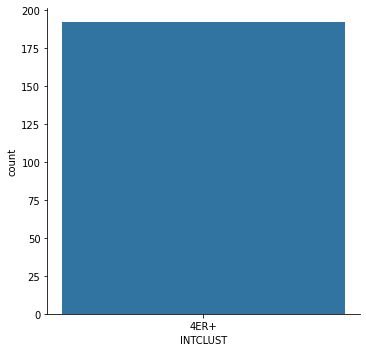

In [79]:
sns.catplot("INTCLUST", kind="count", data=tcga_df)
plt.plot();

In [78]:
y_hat_v2 = minimal_xgb_clf.predict(tcga_df_v2[list(X_gene_train_adj)])
tcga_df_v2["INTCLUST"] = y_hat_v2
tcga_df_v2

Hugo_Symbol,UBE2Q2P2,HMGB1P1,LOC155060,RNU12-2P,SSX9,CXORF67,EFCAB8,SRP14P1,LOC391343,TRIM75P,...,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,TPTEP1,AKR1C6P,INTCLUST
TCGA-A1-A0SB-01,14.3935,116.3870,279.7612,0.4505,0.0,0.9010,0.9010,1.8020,0.0000,0.4505,...,519.4279,1415.9252,19.3716,1364.5681,6186.7327,1931.2986,1436.1978,552.3144,0.0000,6
TCGA-A1-A0SD-01,11.3241,60.2630,83.6986,0.3308,0.0,0.6616,0.3308,4.6315,0.3308,0.3308,...,578.2814,1225.7051,33.0825,868.0837,3559.6725,1278.9678,1195.6000,86.0144,0.0000,6
TCGA-A1-A0SE-01,4.4426,153.1452,74.7018,0.0000,0.0,0.0000,0.9872,5.5944,0.3291,0.3291,...,726.6146,1018.8400,57.5895,960.5923,3007.8157,926.3677,1075.4422,866.1456,0.0000,6
TCGA-A1-A0SF-01,10.7401,141.1933,314.4482,0.0000,0.0,0.0000,2.9988,9.4249,0.0000,0.0000,...,533.3625,1053.4444,94.6772,881.2262,5343.4779,934.3482,508.0867,52.2652,0.8568,6
TCGA-A1-A0SH-01,3.0048,79.8003,95.7054,0.0000,0.0,0.0000,0.3612,3.9727,0.0000,0.0000,...,581.0946,801.3977,19.8634,1353.2389,5464.9614,1312.7898,1001.1151,455.7746,0.0000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-MS-A51U-01,7.9343,150.6834,540.4278,1.5649,0.0,0.5216,0.0000,6.2598,0.0000,0.0000,...,443.9228,1083.4637,40.6886,858.1116,4930.6208,2212.8326,665.6234,249.8696,0.0000,6
TCGA-OL-A66H-01,2.2519,115.3378,338.1985,2.0851,0.0,0.0000,2.0851,4.1701,0.0000,0.0000,...,747.7064,903.6697,10.4254,634.2786,4163.4696,1251.8766,773.1443,5.8382,0.0000,6
TCGA-OL-A66I-01,1.2603,158.3599,210.7460,0.4173,0.0,2.0866,2.5039,2.5039,0.4173,0.0000,...,334.2723,933.1247,206.1555,479.0819,6621.1789,649.3479,780.3860,47.1570,0.0000,6
TCGA-OL-A66J-01,5.0428,124.6327,323.1185,0.4507,0.0,0.0000,8.1118,5.8585,3.1546,0.0000,...,797.6566,1038.3055,13.9703,683.1906,5216.7643,1408.7427,713.3844,567.3727,0.0000,6


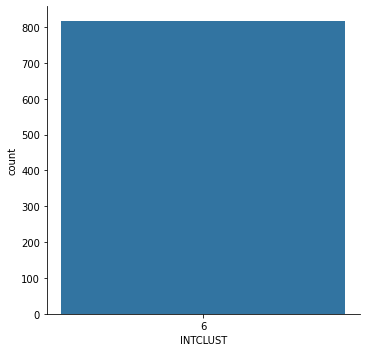

In [80]:
sns.catplot("INTCLUST", kind="count", data=tcga_df_v2)
plt.plot();

## CNA Classifier
### Training and predictions

In [81]:
tcga_cna_df = pd.read_csv("/home/rimichael/Uni/biohack/tcga/tcna_CNA.tsv", 
                          sep="\t", index_col="ID")
tcga_cna_df

,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A,ATAD3B,ATAD3C,AURKAIP1,B3GALT6,C1orf159,...,hsa-mir-1321,hsa-mir-361,hsa-mir-548m,hsa-mir-652,hsa-mir-220a,hsa-mir-513c,hsa-mir-513b,hsa-mir-513a-1,hsa-mir-513a-2,hsa-mir-224
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
TCGA-3C-AALI-01,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,1,1,1,1,-1
TCGA-3C-AALJ-01,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
TCGA-3C-AALK-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-4H-AAAK-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,1,1,1,1,1
TCGA-XX-A899-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-XX-A89A-01,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [82]:
# extract most informative cna given INTCLUST
cna_clf = RFE(RandomForestClassifier(max_depth=25, 
                                 max_leaf_nodes=30, n_estimators=300), 1000, step=250)

cna_clf.fit(X_cna_train, y_cna_train)
cna_clf.score(X_cna_test, y_cna_test)

0.6196172248803827

In [85]:
cna_list = list(X_cna_train.iloc[:, cna_clf.support_])
len(cna_list)

1000

In [86]:
# train cna classifier of intersection of CNAs
common_cna = [cna for cna in list(tcga_cna_df) if cna in cna_list]
common_cna

['MIR548AA1',
 'ACP6',
 'CTSK',
 'ARNT',
 'ANXA9',
 'C1orf56',
 'SEMA6C',
 'TMOD4',
 'VPS72',
 'ZNF687',
 'PSMB4',
 'CGN',
 'TUFT1',
 'SNX27',
 'CELF3',
 'OAZ3',
 'TDRKH',
 'RORC',
 'C2CD4D',
 'THEM5',
 'THEM4',
 'S100A11',
 'TCHHL1',
 'TCHH',
 'RPTN',
 'HRNR',
 'FLG',
 'FLG-AS1',
 'FLG2',
 'CRNN',
 'LCE5A',
 'CRCT1',
 'LCE2D',
 'LCE2B',
 'LCE4A',
 'C1orf68',
 'SPRR4',
 'SPRR1A',
 'SPRR3',
 'SPRR1B',
 'SPRR2D',
 'SPRR2A',
 'SPRR2B',
 'SPRR2E',
 'SPRR2F',
 'SPRR2C',
 'SPRR2G',
 'S100A8',
 'S100A4',
 'S100A5',
 'S100A6',
 'S100A2',
 'S100A16',
 'S100A13',
 'S100A1',
 'ILF2',
 'INTS3',
 'SLC27A3',
 'SLC39A1',
 'RAB13',
 'C1orf189',
 'C1orf43',
 'AQP10',
 'ATP8B2',
 'IL6R',
 'TDRD10',
 'ADAR',
 'ADAM15',
 'TRIM46',
 'YY1AP1',
 'SYT11',
 'SCARNA4',
 'SSR2',
 'SLC25A44',
 'TMEM79',
 'VHLL',
 'C1orf61',
 'MEF2D',
 'IQGAP3',
 'TTC24',
 'APOA1BP',
 'GPATCH4',
 'BCAN',
 'ISG20L2',
 'RRNAD1',
 'HDGF',
 'CD1C',
 'CD1B',
 'CD1E',
 'SPTA1',
 'AIM2',
 'DCAF8',
 'COPA',
 'SUMO1P3',
 'VANGL2',
 'CD48',

In [87]:
print(X_cna_train[common_cna].shape)
X_cna_train[common_cna].head()

(1480, 987)


,MIR548AA1,ACP6,CTSK,ARNT,ANXA9,C1orf56,SEMA6C,TMOD4,VPS72,ZNF687,...,SOX9-AS1,SOX9,SLC39A11,C17orf80,TTYH2,FADS6,TRIM47,SRP68,CBX4,TNPO2
MB-5300,1,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,0
MB-4648,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,0
MB-0899,0,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,1,-1
MB-4317,2,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,2
MB-4333,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [88]:
min_cna_clf = RandomForestClassifier(max_depth=25, 
                                 max_leaf_nodes=30, n_estimators=300)

min_cna_clf.fit(X_cna_train[common_cna], y_cna_train)
min_cna_clf.score(X_cna_test[common_cna], y_cna_test)

0.6244019138755981

In [89]:
y_hat_cna = min_cna_clf.predict(tcga_cna_df[common_cna])
y_hat_cna

array(['10', '10', '5', ..., '4ER+', '8', '8'], dtype=object)

In [90]:
tcga_cna_df["INTCLUST_CNA"] = y_hat_cna
tcga_cna_df

,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A,ATAD3B,ATAD3C,AURKAIP1,B3GALT6,C1orf159,...,hsa-mir-361,hsa-mir-548m,hsa-mir-652,hsa-mir-220a,hsa-mir-513c,hsa-mir-513b,hsa-mir-513a-1,hsa-mir-513a-2,hsa-mir-224,INTCLUST_CNA
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,10
TCGA-3C-AALI-01,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,1,1,1,1,-1,10
TCGA-3C-AALJ-01,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,5
TCGA-3C-AALK-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
TCGA-4H-AAAK-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,1,1,1,1,1,8
TCGA-XX-A899-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
TCGA-XX-A89A-01,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,4ER+


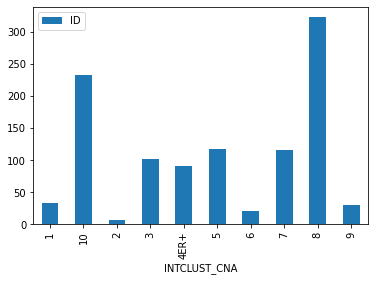

In [91]:
tcga_cna_df[["INTCLUST_CNA"]].reset_index().groupby("INTCLUST_CNA").count().plot(kind="bar")

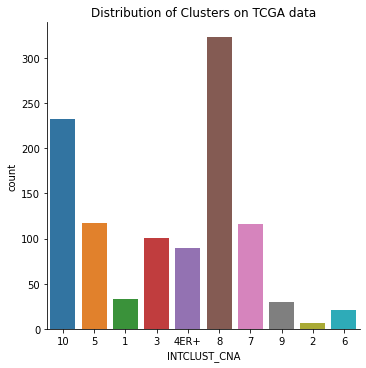

In [92]:
sns.catplot("INTCLUST_CNA", kind="count", data=tcga_cna_df)
plt.title("Distribution of Clusters on TCGA data")
plt.show();